In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.5 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
from math import sqrt
from cvxopt import matrix
from cvxopt import solvers
from cvxopt.blas import dot
from cvxopt.solvers import qp
import pylab
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import scipy.stats as sp 
import seaborn as sns
import itertools
import seaborn as sns
solvers.options['show_progress'] = False

In [3]:
selected_stocks = ['BTC-USD','GC=F', 'MXN=X','^MXX']
raw = yf.download(selected_stocks,"2021-01-01","2021-11-30") 
precios_cierre = pd.DataFrame(raw.Close).dropna().iloc[:201,:]
retpor = np.diff(precios_cierre, axis = 0)/precios_cierre.iloc[:-1,:]

[*********************100%***********************]  4 of 4 completed


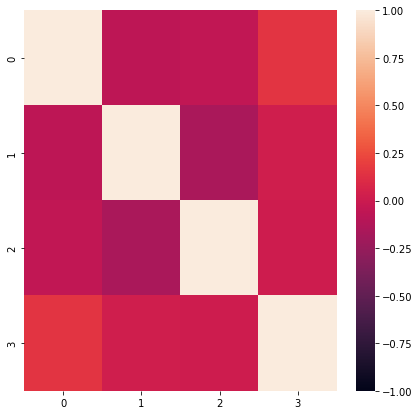

In [4]:
cov_m = np.corrcoef(retpor.T)
fig = plt.figure(figsize = (7, 7))
ax = sns.heatmap(cov_m, vmin=-1, vmax=1)

# Restricción de Ganancia Mínima (solución analítica)

El método visto en clase tiene un constraint en cuanto a la ganancia:


$$ \underset{w \in \mathbb{R}^p}{\text{min}} \frac{1}{2}  w^t \Sigma w$$

 con la restricción:

 $$ w^t g \geq G$$

In [5]:
valsG = np.linspace(0,0.5,100)
E_in = retpor.cov()
g = retpor.mean()

In [6]:
def pesos_ganancia_minima(ganancia):
  return ganancia * ((np.linalg.inv(E_in)@g)/(g.T @ np.linalg.inv(E_in)@g))

In [7]:
pesos_ganancia_minima(.004749)

array([ 0.47266004, -0.93453704,  0.68232461,  2.73055503])

In [8]:
pesos_ganancia_minima(.000188)

array([ 0.01871133, -0.03699578,  0.02701138,  0.10809525])

# Restricción de alocación de todo el capital

> Indented block



En este método no se especifica un nivel mínimo de ganancia $G$. En este caso, se introduce un parámetro $\phi$ que representa la aversión al riesgo (mientras más grande más averso al riesgo). También se introduce un nuevo constraint que no se encontraba presente antes y que especifica que todo el capital debe ser invertido. 


El planteamiento es:

$$ \underset{w \in \mathbb{R}^p}{\text{min}} \frac{1}{2}  w^t \Sigma w - \frac{1}{\phi} w^t g$$

sujeto a:

$$ \boldsymbol{1^t} w = 1$$

Notar que $\phi$ es un parámetro, y que la adicion del término $\frac{1}{\phi} w^t g$ en este planteamiento hace que en este caso se busque obtener el portafolio (i.e. los pesos) que minimizan el riesgo y maximizan la ganancia, sin imponer una restriccioń explícita en un nivel mínimo de ganancia o nivel máximo de riesgo, sino controlando todo a través de $\phi$.

In [9]:
S = matrix(
    [[ 0.002706, -0.000033, -1.916605e-05	,6.999402e-05],
    [ -0.000033	, 0.000091, -1.038888e-05	,2.299984e-06],
    [-0.000019	, -0.000010	, 4.653256e-05	,5.655895e-07],
    [ 0.000070,0.000002	,5.655895e-07	,7.788368e-05]])

S2 = matrix(
    [[ 4e-2, 6e-3, -4e-3,0.0],
    [ 6e-3, 1e-2, 0.0,0.0],
    [-4e-3, 0.0, 2.5e-3,0.0],
    [ 0.0,0.0,0.0,0.0 ]])

pbar = matrix([0.004749, -0.000324, 0.000108, 0.000779])

pbar2 = matrix([1.0, 1.0, 1.0, 1.0])

In [10]:

# Problem data.
n = len(g)




## Restriccioń de alocacioń de todo el capital
# Esta matriz tiene que ver con la rstricción 1T x = 1 y 
#es una matriz (o mas bien vector) de 1 (parte izq)
A = matrix(1.0, (1,n))
# es escalar 1 que es la parte derecha de 1T x = 1
b = matrix(1.0)




# Definición de número de valores de phi que se van a calcular.
N = 100
# mu es el riesgo que se está dispuesto a tomar (mientras más bajo sea, más riesgo se está dispuesto a tomar)
# un valor de este mu de 0 indica que no importa el riesgo, solo se busca el mayor valor esperado
# un valor de mu que sea muy grande indica que no se quiere tomar riesgo. 
phis = [ 10**(5.0*t/N-1.0) for t in range(N) ]
portfolios = [ qp(P = phi*S, q = -pbar,A= A, b =b)['x'] for phi in phis ]
returns = [ dot(pbar,x) for x in portfolios ]
risks = [ sqrt(dot(x, S*x)) for x in portfolios ]


In [11]:
risks_df = np.array(risks)
returns_df = np.array(returns)
rest_todo_capital = pd.DataFrame(data = {"riesgo":risks_df,"retorno": returns_df, "phi": phis})

In [12]:
rest_todo_capital.head()

,riesgo,retorno,phi
0,1.158397,0.134220,0.100000
1,1.032424,0.119644,0.112202
2,0.920150,0.106653,0.125893
3,0.820087,0.095075,0.141254
4,0.730905,0.084756,0.158489


In [13]:
rest_todo_capital.tail()

,riesgo,retorno,phi
95,0.004454,0.000189,5623.413252
96,0.004454,0.000189,6309.573445
97,0.004454,0.000188,7079.457844
98,0.004454,0.000188,7943.282347
99,0.004454,0.000188,8912.509381


Text(0, 0.5, 'Retorno %')

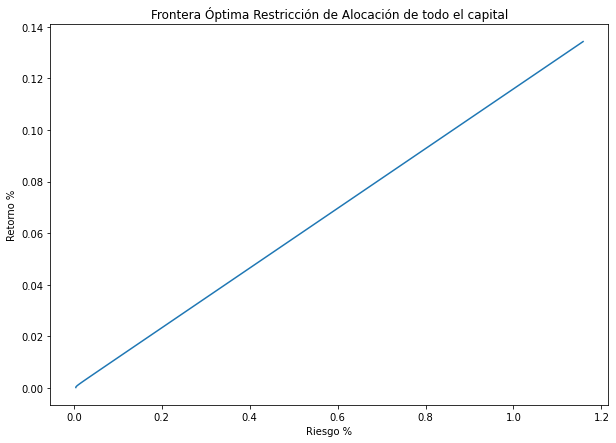

In [14]:
ax = rest_todo_capital.plot.line(x="riesgo", y="retorno", title = "Frontera Óptima Restricción de Alocación de todo el capital", legend=False, figsize=(10,7))
ax.set_xlabel("Riesgo %")
ax.set_ylabel("Retorno %")

## Portafolio con Mayor Riesgo y Mayor Rendimiento

In [15]:
(np.round(portfolios[0], decimals = 3))

array([[ 14.343],
       [-55.008],
       [-23.585],
       [ 65.251]])

Notar que un riesgo de 1.15, es equivalente a decir que a una desviación estándar, el retorno esperado límite inferior es 0.13 -1.15 , lo cuál da como resultado -1.02. Recordando que este es un retorno esperado sobre el capital (en este caso una pérdida esperada, por el signo), el hecho de que sea mayor a 1 significa que puedes perder todo tu capital (A UNA DESVIACIÓN ESTÁNDAR).

In [16]:
rest_todo_capital.iloc[0]

riesgo     1.158397
retorno    0.134220
phi        0.100000
Name: 0, dtype: float64

In [17]:
g@ np.array(portfolios[0]) 

array([0.13422758])

In [18]:
rest_todo_capital.iloc[-1]

riesgo        0.004454
retorno       0.000188
phi        8912.509381
Name: 99, dtype: float64

In [19]:
np.round(portfolios[-1], decimals = 3)

array([[0.008],
       [0.269],
       [0.486],
       [0.236]])

In [20]:
g@ np.array(portfolios[-1]) 

array([0.00018806])

# Restricción de No Ventas en Corto


In [21]:
# Problem data.
n = len(g)

# Restriccioń de no ventas en corto
# G es la matriz identidad y tiene que ver con la restricción x >= 0 (parte derecha G x)
G = matrix(0.0, (n,n))
G[::n+1] = -1.0
# h es un vector de ceros y es el lado derecho de la restriccioń x >= 0
h = matrix(0.0, (n,1))

# Definición de número de valores de phi que se van a calcular.
N = 100
# mu es el riesgo que se está dispuesto a tomar (mientras más bajo sea, más riesgo se está dispuesto a tomar)
# un valor de este mu de 0 indica que no importa el riesgo, solo se busca el mayor valor esperado
# un valor de mu que sea muy grande indica que no se quiere tomar riesgo. 
phis = [ 10**(5.0*t/N-1.0) for t in range(N) ]
portfolios = [ qp(phi*S, -pbar, G = G, h = h)['x'] for phi in phis ]

returns = [ dot(pbar,x) for x in portfolios ]
risks = [ sqrt(dot(x, S*x)) for x in portfolios ]


In [22]:
risks_df = np.array(risks)
returns_df = np.array(returns)
rest_ventas_corto = pd.DataFrame(data = {"riesgo":risks_df,"retorno": returns_df, "phi": phis})

In [23]:
rest_ventas_corto.head()

,riesgo,retorno,phi
0,1.198888,0.143725,0.100000
1,1.068510,0.128095,0.112202
2,0.952310,0.114165,0.125893
3,0.848748,0.101750,0.141254
4,0.756447,0.090684,0.158489


In [24]:
rest_ventas_corto.tail()

,riesgo,retorno,phi
95,0.000021,0.000003,5623.413252
96,0.000019,0.000002,6309.573445
97,0.000017,0.000002,7079.457844
98,0.000015,0.000002,7943.282347
99,0.000014,0.000002,8912.509381


Text(0, 0.5, 'Retorno %')

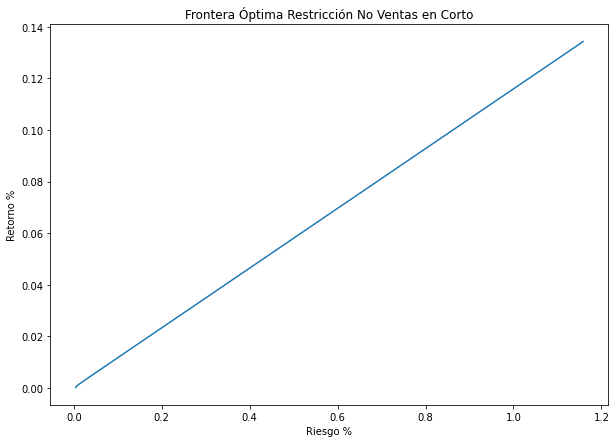

In [25]:
ax = rest_todo_capital.plot.line(x="riesgo", y="retorno", title = "Frontera Óptima Restricción No Ventas en Corto", legend=False, figsize=(10,7))
ax.set_xlabel("Riesgo %")
ax.set_ylabel("Retorno %")

In [26]:
np.round(portfolios[0], decimals = 3)

array([[15.531],
       [ 0.   ],
       [28.563],
       [85.855]])

In [27]:
rest_ventas_corto.iloc[0]

riesgo     1.198888
retorno    0.143725
phi        0.100000
Name: 0, dtype: float64

In [28]:
g@ np.array(portfolios[0]) 

array([0.14374782])

In [29]:
rest_ventas_corto.iloc[-1]

riesgo        0.000014
retorno       0.000002
phi        8912.509381
Name: 99, dtype: float64

Notar que el retorno es mucho más bajo debido a que se quitó la restriccioń de tener que utilizar todo el capital

In [30]:
np.round(portfolios[-1], decimals = 3)

array([[0.   ],
       [0.   ],
       [0.   ],
       [0.001]])

In [31]:
g@ np.array(portfolios[-1]) 

array([1.61653566e-06])

# Restricción de No Apalancamiento

Esta restricción se implementa de forma indirecta, pues implementar la restricción de alocación de todo el capital más la restricción de no ventas en corto equivale a implementar la restricción de no apalancamiento

In [32]:
# Problem data.
n = len(g)
# Restriccioń de no ventas en corto
# G es la matriz identidad y tiene que ver con la restricción x >= 0 (parte derecha G x)
G = matrix(0.0, (n,n))
G[::n+1] = -1.0
# h es un vector de ceros y es el lado derecho de la restriccioń x >= 0
h = matrix(0.0, (n,1))

## Restriccioń de alocacioń de todo el capital
# Esta matriz tiene que ver con la rstricción 1T x = 1 y es una matriz (o mas bien vector) de 1 (parte izq)
A = matrix(1.0, (1,n))
# es escalar 1 que es la parte derecha de 1T x = 1
b = matrix(1.0)

# Definición de número de valores de phi que se van a calcular.
N = 100
phis = [ 10**(5.0*t/N-1.0) for t in range(N) ]
portfolios = [ qp(phi*S, -pbar, G, h, A, b)['x'] for phi in phis ]


returns = [ dot(pbar,x) for x in portfolios ]
risks = [ sqrt(dot(x, S*x)) for x in portfolios ]

In [33]:
risks_df = np.array(risks)
returns_df = np.array(returns)
rest_apalancamiento = pd.DataFrame(data = {"riesgo":risks_df,"retorno": returns_df, "phi": phis})

In [34]:
rest_apalancamiento.head()

,riesgo,retorno,phi
0,0.052019,0.004749,0.100000
1,0.052019,0.004749,0.112202
2,0.052019,0.004749,0.125893
3,0.052019,0.004749,0.141254
4,0.052019,0.004749,0.158489


In [35]:
rest_apalancamiento.tail()

,riesgo,retorno,phi
95,0.004454,0.000189,5623.413252
96,0.004454,0.000189,6309.573445
97,0.004454,0.000188,7079.457844
98,0.004454,0.000188,7943.282347
99,0.004454,0.000188,8912.509381


Text(0, 0.5, 'Retorno %')

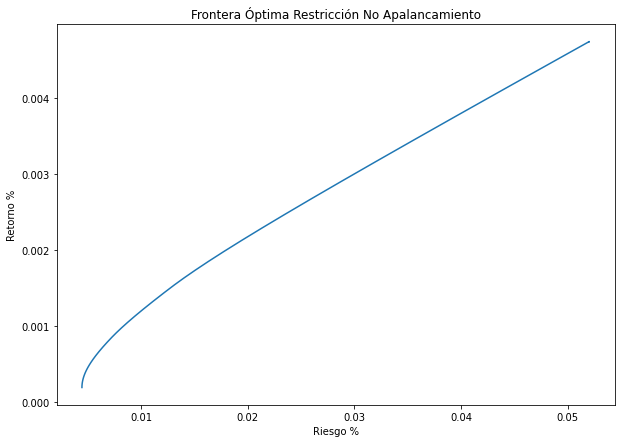

In [36]:
ax = rest_apalancamiento.plot.line(x="riesgo", y="retorno", title = "Frontera Óptima Restricción No Apalancamiento", legend=False, figsize=(10,7))
ax.set_xlabel("Riesgo %")
ax.set_ylabel("Retorno %")

In [37]:
np.round(portfolios[0], decimals = 3)

array([[1.],
       [0.],
       [0.],
       [0.]])

In [38]:
rest_apalancamiento.iloc[0]

riesgo     0.052019
retorno    0.004749
phi        0.100000
Name: 0, dtype: float64

In [39]:
g@ np.array(portfolios[0]) 

array([0.00474932])

In [40]:
rest_apalancamiento.iloc[-1]

riesgo        0.004454
retorno       0.000188
phi        8912.509381
Name: 99, dtype: float64

In [41]:
np.round(portfolios[-1], decimals = 3)

array([[0.008],
       [0.269],
       [0.486],
       [0.236]])

In [42]:
g@ np.array(portfolios[-1]) 

array([0.00018806])

# Restricción de activo libre de riesgo

Notar que para poder aplicar la solución analítica, se está estableciendo de forma implicita la restricción de alocación de todo el capital.  

In [43]:

S_con_riesgo = matrix(
    [[ 0.002706, -0.000033, -1.916605e-05	,6.999402e-05, 0],
    [ -0.000033	, 0.000091, -1.038888e-05	,2.299984e-06, 0],
    [-0.000019	, -0.000010	, 4.653256e-05	,5.655895e-07, 0],
    [ 0.000070,0.000002	,5.655895e-07	,7.788368e-05, 0],
     [ 0,0,0	,0, 0]])


# rendimiento del activo libre de riesgo
# se asume que la varianza del activo libre de riesgo es 0 y su covarianza con los
# otros activos también es 0
r = 0.00001

In [44]:
def pesos_activos_riesgo(phi):
  pesos_riesgo = ((1/phi) * np.linalg.inv(S) @ 
                  (pbar.T - (r *np.repeat(1,4))).T )
  peso_act_libre =1 - pesos_riesgo.sum()
  return np.append(pesos_riesgo,peso_act_libre)


In [45]:
pesos_riesgo = [ pesos_activos_riesgo(phi) for phi in phis ]

In [46]:
# verificando que la suma de los pesos es uno
pesos_riesgo[0].sum()

1.0

In [47]:
rest_libre_riesgo = np.zeros((100,3))
rest_libre_riesgo[:,2] = phis
for i in range(100):
  rend = pesos_riesgo[i] @ np.append(pbar, r)
  risk = float(np.array(pesos_riesgo[i]).reshape(5,1).T @ S_con_riesgo @ np.array(pesos_riesgo[i]).reshape(5,1)) 
  rest_libre_riesgo[i,0] = rend
  rest_libre_riesgo[i,1] = risk
rest_libre_riesgo = pd.DataFrame(data = {"riesgo":rest_libre_riesgo[:,1],"retorno": rest_libre_riesgo[:,0], "phi": rest_libre_riesgo[:,2]})

In [48]:
rest_libre_riesgo.head()

,riesgo,retorno,phi
0,1.496787,0.149689,0.100000
1,1.188940,0.133411,0.112202
2,0.944409,0.118904,0.125893
3,0.750170,0.105974,0.141254
4,0.595882,0.094451,0.158489


In [49]:
rest_libre_riesgo.tail()

,riesgo,retorno,phi
95,4.733256e-10,0.000013,5623.413252
96,3.759759e-10,0.000012,6309.573445
97,2.986482e-10,0.000012,7079.457844
98,2.372247e-10,0.000012,7943.282347
99,1.884343e-10,0.000012,8912.509381


Text(0, 0.5, 'Retorno %')

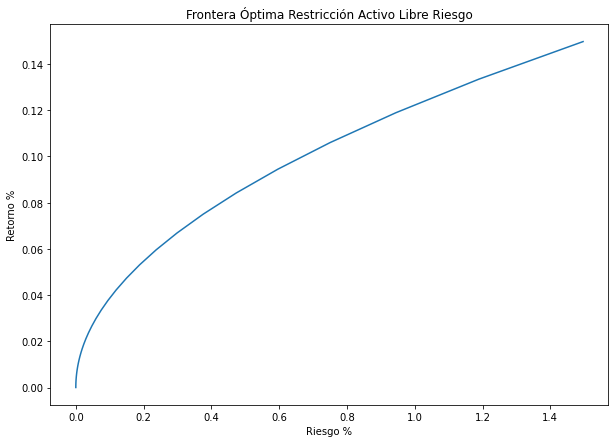

In [50]:
ax = rest_libre_riesgo.plot.line(x="riesgo", y="retorno", title = "Frontera Óptima Restricción Activo Libre Riesgo", legend=False, figsize=(10,7))
ax.set_xlabel("Riesgo %")
ax.set_ylabel("Retorno %")

In [51]:
np.round(pesos_riesgo[0].reshape(5,1), decimals = 3)

array([[ 15.046],
       [-31.018],
       [ 19.287],
       [ 85.991],
       [-88.307]])

In [52]:
rest_libre_riesgo.iloc[0]

riesgo     1.496787
retorno    0.149689
phi        0.100000
Name: 0, dtype: float64

In [53]:
np.append(pbar, r) @ np.array(pesos_riesgo[0]) 

0.1496886879100926

In [54]:
np.round(pesos_riesgo[-1].reshape(5,1), decimals = 3)

array([[ 0.   ],
       [-0.   ],
       [ 0.   ],
       [ 0.001],
       [ 0.999]])

In [55]:
rest_libre_riesgo.iloc[-1]

riesgo     1.884343e-10
retorno    1.167942e-05
phi        8.912509e+03
Name: 99, dtype: float64

In [56]:
np.round(pesos_riesgo[-1], decimals = 2)

array([ 0., -0.,  0.,  0.,  1.])

In [57]:
np.append(pbar, r) @ np.array(pesos_riesgo[-1]) 

1.1679422500508281e-05

# Restricción de Intervalos de alocación

In [58]:
#Creación de la matriz con intervalos
# .2 <=x1 <=.5
#  .1 <=     x4 <=.3
# notar que implicitamente se está poniendo la restricción de no venta en corto para 
# x1 y x4, y que explícitamente se pone esta restricción para x_2 y x_3
G = matrix(
    [[ 1.0, -1.0, 0.0	,0.0,0.0,0.0],
     [0,      0     , -1.0	,0,0,0],
    [ 0	, 0, 0	,-1.0,0,0],
    [0	, 0	,0	,0,1.0,-1.0]])

h = matrix([.5,
            -.2,
            0,
            0,
            .3,
            -.1])

In [59]:
# Problem data.
n = len(g)


# Definición de número de valores de phi que se van a calcular.
N = 100
phis = [ 10**(5.0*t/N-1.0) for t in range(N) ]

portfolios = [ qp(phi*S, -pbar, G=G, h=h)['x'] for phi in phis ]

returns = [ dot(pbar,x) for x in portfolios ]
risks = [ sqrt(dot(x, S*x)) for x in portfolios ]


In [60]:
risks_df = np.array(risks)
returns_df = np.array(returns)
rest_intervalo= pd.DataFrame(data = {"riesgo":risks_df,"retorno": returns_df, "phi": phis})

In [61]:
rest_intervalo.head()

,riesgo,retorno,phi
0,0.160534,0.005137,0.100000
1,0.143581,0.004864,0.112202
2,0.128530,0.004621,0.125893
3,0.115182,0.004405,0.141254
4,0.103358,0.004212,0.158489


In [62]:
rest_intervalo.tail()

,riesgo,retorno,phi
95,0.010532,0.001012,5623.413252
96,0.010532,0.001012,6309.573445
97,0.010532,0.001012,7079.457844
98,0.010532,0.001012,7943.282347
99,0.010532,0.001012,8912.509381


Text(0, 0.5, 'Retorno %')

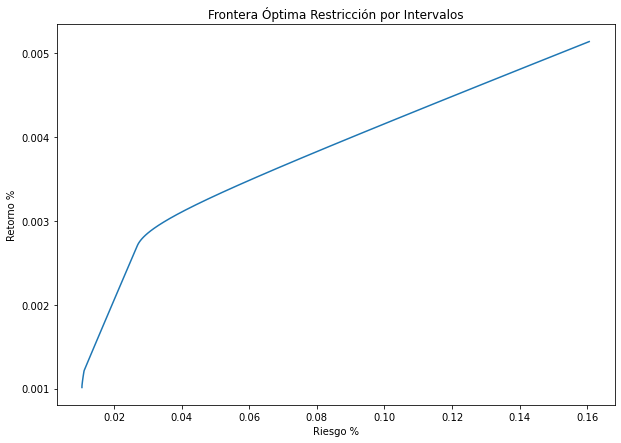

In [63]:
ax = rest_intervalo.plot.line(x="riesgo", y="retorno", title = "Frontera Óptima Restricción por Intervalos", legend=False, figsize=(10,7))
ax.set_xlabel("Riesgo %")
ax.set_ylabel("Retorno %")

In [64]:
np.round(portfolios[0], decimals = 3)

array([[ 0.5  ],
       [ 0.   ],
       [23.412],
       [ 0.3  ]])

In [65]:
rest_intervalo.iloc[0]

riesgo     0.160534
retorno    0.005137
phi        0.100000
Name: 0, dtype: float64

In [66]:
g@ np.array(portfolios[0]) 

array([0.00514598])

In [67]:
rest_intervalo.iloc[-1]

riesgo        0.010532
retorno       0.001012
phi        8912.509381
Name: 99, dtype: float64

In [68]:
np.round(portfolios[-1], decimals = 3)

array([[0.2  ],
       [0.081],
       [0.099],
       [0.1  ]])

In [69]:
g@ np.array(portfolios[-1]) 

array([0.00101232])

## Añadiendo restriccion de alocación de todos los activos

In [70]:
# Problem data.
n = len(g)

## Restriccioń de alocacioń de todo el capital
# Esta matriz tiene que ver con la rstricción 1T x = 1 y es una matriz (o mas bien vector) de 1 (parte izq)
A = matrix(1.0, (1,n))
# es escalar 1 que es la parte derecha de 1T x = 1
b = matrix(1.0)

# Definición de número de valores de phi que se van a calcular.
N = 100
phis = [ 10**(5.0*t/N-1.0) for t in range(N) ]
portfolios = [ qp(phi*S, -pbar, G, h, A, b)['x'] for phi in phis ]


returns = [ dot(pbar,x) for x in portfolios ]
risks = [ sqrt(dot(x, S*x)) for x in portfolios ]


In [71]:
risks_df = np.array(risks)
returns_df = np.array(returns)
rest_intervalo= pd.DataFrame(data = {"riesgo":risks_df,"retorno": returns_df, "phi": phis})

In [72]:
rest_intervalo.head()

,riesgo,retorno,phi
0,0.026507,0.00263,0.100000
1,0.026507,0.00263,0.112202
2,0.026507,0.00263,0.125893
3,0.026507,0.00263,0.141254
4,0.026507,0.00263,0.158489


In [73]:
rest_intervalo.tail()

,riesgo,retorno,phi
95,0.010863,0.000988,5623.413252
96,0.010863,0.000988,6309.573445
97,0.010863,0.000988,7079.457844
98,0.010863,0.000988,7943.282347
99,0.010863,0.000988,8912.509381


Text(0, 0.5, 'Retorno %')

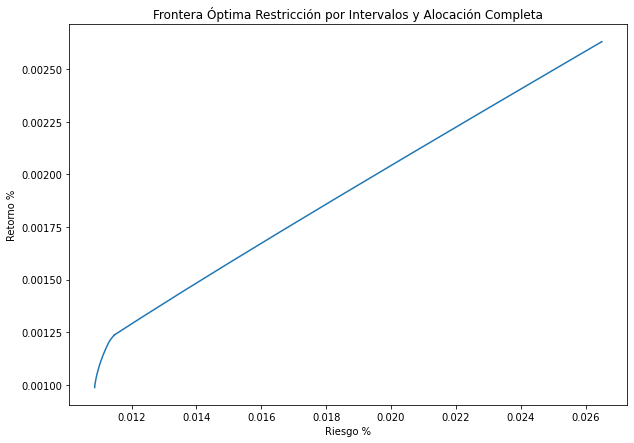

In [74]:
ax = rest_intervalo.plot.line(x="riesgo", y="retorno", title = "Frontera Óptima Restricción por Intervalos y Alocación Completa", legend=False, figsize=(10,7))
ax.set_xlabel("Riesgo %")
ax.set_ylabel("Retorno %")

In [75]:
np.round(portfolios[0], decimals = 3)

array([[0.5],
       [0. ],
       [0.2],
       [0.3]])

In [76]:
rest_intervalo.iloc[0]

riesgo     0.026507
retorno    0.002630
phi        0.100000
Name: 0, dtype: float64

In [77]:
g@ np.array(portfolios[0]) 

array([0.00263006])

Notar que al forzar que se invierta todo el capital, se obtiene un portafolio con un riesgo más alto y un retorno más bajo en comparación cuando se usa también la restricción de intervalos pero sin la restricción de alocaccioń de todo el capital (ejemplo pasado).

In [78]:
rest_intervalo.iloc[-1]

riesgo        0.010863
retorno       0.000988
phi        8912.509381
Name: 99, dtype: float64

Notar que aún cuando se esperaría que la solución fuera asignar todo el capital al activo con menos riesgo, hay que notar que en la matriz de var-cov, las estructuras de correlación influyen y logran obtener un portafolio con menos riesgo ( 0.0045) considerando que el activo menos riesgoso tiene un riesgo de (0.0088)

In [79]:
np.round(portfolios[-1], decimals = 3)

array([[0.2  ],
       [0.268],
       [0.432],
       [0.1  ]])

In [80]:
retpor.std()

BTC-USD    0.052017
GC=F       0.009555
MXN=X      0.006821
^MXX       0.008825
dtype: float64

In [81]:
g@ np.array(portfolios[-1]) 

array([0.00098784])

# Restricción de Intervalos de alocación por grupos

In [82]:
#Creación de la matriz con intervalos
# .2 <=x1+x3 <=.5
#  .1 <=   x2+ x4 <=.3
# notar que implicitamente se está poniendo la restricción de no venta en corto para 
# x1 y x4, y que explícitamente se pone esta restricción para x_2 y x_3
G = matrix(
    [[ 1.0,  -1.0,  0	,  0, -1.0,0, 0,0],
       [0,    0    , 1.0,  -1.0,  0,-1.0, 0 ,0],
       [ 1.0, -1.0,  0	, 0, 0,0, -1.0, 0],
       [0,    0	    ,1.0,   -1.0, 0,0, 0 , -1.0]])

h = matrix([.5,
            -.2,
            .3,
            -.1,
            0,
            0,
            0,
            0])

In [83]:
# Problem data.
n = len(g)

## Restriccioń de alocacioń de todo el capital
# Esta matriz tiene que ver con la rstricción 1T x = 1 y es una matriz (o mas bien vector) de 1 (parte izq)


# Definición de número de valores de phi que se van a calcular.
N = 100
phis = [ 10**(5.0*t/N-1.0) for t in range(N) ]

portfolios = [ qp(phi*S, -pbar, G=G, h=h)['x'] for phi in phis ]

returns = [ dot(pbar,x) for x in portfolios ]
risks = [ sqrt(dot(x, S*x)) for x in portfolios ]

In [84]:
risks_df = np.array(risks)
returns_df = np.array(returns)
rest_intervalo_grupos= pd.DataFrame(data = {"riesgo":risks_df,"retorno": returns_df, "phi": phis})

In [85]:
rest_intervalo_grupos.head()

,riesgo,retorno,phi
0,0.026543,0.002608,0.100000
1,0.026543,0.002608,0.112202
2,0.026543,0.002608,0.125893
3,0.026543,0.002608,0.141254
4,0.026543,0.002608,0.158489


In [86]:
rest_intervalo_grupos.tail()

,riesgo,retorno,phi
95,0.001428,0.000054,5623.413252
96,0.001428,0.000053,6309.573445
97,0.001428,0.000053,7079.457844
98,0.001428,0.000053,7943.282347
99,0.001428,0.000053,8912.509381


Text(0, 0.5, 'Retorno %')

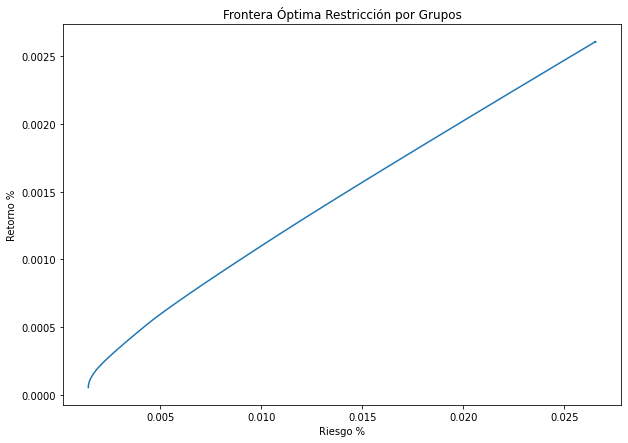

In [87]:
ax = rest_intervalo_grupos.plot.line(x="riesgo", y="retorno", title = "Frontera Óptima Restricción por Grupos", legend=False, figsize=(10,7))
ax.set_xlabel("Riesgo %")
ax.set_ylabel("Retorno %")

In [88]:
np.round(portfolios[0], decimals = 3)

array([[0.5],
       [0. ],
       [0. ],
       [0.3]])

In [89]:
rest_intervalo_grupos.iloc[0]

riesgo     0.026543
retorno    0.002608
phi        0.100000
Name: 0, dtype: float64

In [90]:
g@ np.array(portfolios[0]) 

array([0.00260839])

In [91]:
rest_intervalo_grupos.iloc[-1]

riesgo        0.001428
retorno       0.000053
phi        8912.509381
Name: 99, dtype: float64

In [92]:
np.round(portfolios[-1], decimals = 3)

array([[0.004],
       [0.061],
       [0.196],
       [0.039]])

In [93]:
g@ np.array(portfolios[-1]) 

array([5.27324187e-05])

# Restricción de cardinalidad o número de activos

In [94]:
combinaciones = list(itertools.combinations([0,1,2,3], r = 3))

In [95]:
list(combinaciones[1])

[0, 1, 3]

In [96]:
(retpor.iloc[:,list(combinaciones[1])]).cov()

,BTC-USD,GC=F,^MXX
BTC-USD,0.002706,-0.000033,0.000070
GC=F,-0.000033,0.000091,0.000002
^MXX,0.000070,0.000002,0.000078


In [97]:
print(matrix(np.matrix((retpor.iloc[:,list(combinaciones[1])]).cov())))

[ 2.71e-03 -3.25e-05  7.00e-05]
[-3.25e-05  9.13e-05  2.30e-06]
[ 7.00e-05  2.30e-06  7.79e-05]



In [99]:
riesgos_todos = []
retornos_todos = []
for combinacion in combinaciones:
  # cálculo de parámetros
  datos_combinacion = retpor.iloc[:,list(combinacion)]
  S = matrix(np.matrix((retpor.iloc[:,list(combinaciones[1])]).cov()))
  pbar = matrix(np.matrix((datos_combinacion).mean()).T)
  # 
  n = len(pbar)


  # Restriccioń de no ventas en corto
  # G es la matriz identidad y tiene que ver con la restricción x >= 0 (parte derecha G x)
  G = matrix(0.0, (n,n))
  G[::n+1] = -1.0
  # h es un vector de ceros y es el lado derecho de la restriccioń x >= 0
  h = matrix(0.0, (n,1))

  ## Restriccioń de alocacioń de todo el capital
  # Esta matriz tiene que ver con la rstricción 1T x = 1 y es una matriz (o mas bien vector) de 1 (parte izq)
  A = matrix(1.0, (1,n))
  # es escalar 1 que es la parte derecha de 1T x = 1
  b = matrix(1.0)

  # Definición de número de valores de phi que se van a calcular.
  N = 100
  phis = [ 10**(5.0*t/N-1.0) for t in range(N) ]
  portfolios = [ qp(phi*S, -pbar, G, h, A, b)['x'] for phi in phis ]


  returns = [ dot(pbar,x) for x in portfolios ]
  retornos_todos.append(returns)
  risks = [ sqrt(dot(x, S*x)) for x in portfolios ]
  riesgos_todos.append(risks)
  




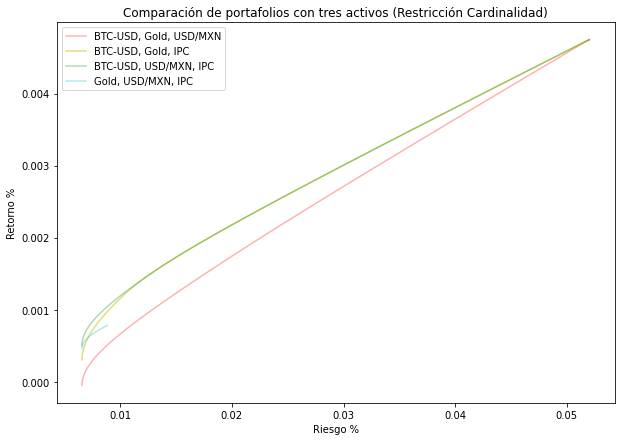

In [100]:
figure(figsize=(10, 7))
plt.plot(riesgos_todos[0], retornos_todos[0], alpha = 0.3, color = "r", label ="BTC-USD, Gold, USD/MXN")
plt.plot(riesgos_todos[1], retornos_todos[1], alpha = 0.5, color = "y", label ="BTC-USD, Gold, IPC")
plt.plot(riesgos_todos[2], retornos_todos[2], alpha = 0.3, color = "g", label ="BTC-USD, USD/MXN, IPC")
plt.plot(riesgos_todos[3], retornos_todos[3], alpha = 0.3, color ="c", label ="Gold, USD/MXN, IPC")
plt.legend()
plt.title("Comparación de portafolios con tres activos (Restricción Cardinalidad)")
plt.xlabel("Riesgo %")
plt.ylabel("Retorno %")

plt.show()

Notar que en la gráfica de arriba, el portafolio  verde es el óptimo con respecto a los demás para todos los niveles de riesgo (aunque para riesgos altos, se obtienen casi los mismos rendimientos esperados)

In [101]:
np.max(riesgos_todos[3])

0.008825171935245705

In [102]:
np.max(retornos_todos[3])

0.0007790742397789788